In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Cargamos el dataset**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Ciencia_de_Datos/Segundo Parcial/Proyecto/Primer_avance/dataset-limpio.csv')

In [ ]:
df

,Source,title,doi,abstract,keywords,Year,Source title,Funding Details,References,Affiliations,Correspondence Address,Authors,Cited by,Editors,Publisher,Sponsors,Abbreviated Source Title,Document Type,Publication Stage,number
0,Scopus,explaining nonadoption blockchain technology g...,10.1007/s40812-023-00296-8,business potential blockchain technology globa...,blockchain d21 d22 f23 general purpose technol...,2024,journal industrial business economics,NaN,annals transaction cost theory past progress c...,fhnw school business university applied scienc...,jp lindeque fhnw school business university ap...,hubenova lindeque jp peter mk,0.0,NaN,springer nature,NaN,j ind bus econ,article,final,NaN
1,Scopus,smartcircular strategies managing biomass reso...,10.1016/j.enconman.2024.118690,growing global population need sustainable ene...,biomass management challenges cifdematel cifqf...,2024,energy conversion management,NaN,feleke cole sm sekabira h djouaka r manyong v ...,management department faculty economics manage...,alimohammadlou management department faculty e...,alinejad alimohammadlou abbasi mirghaderi sh,0.0,NaN,elsevier ltd,NaN,energy convers manage,article,final,NaN
2,Scopus,blockchain urban governance enhancing trust sm...,10.1016/j.scs.2024.105438,rapid urbanization increasing energy demands n...,blockchain long shortterm memory smart cities ...,2024,sustainable cities society,NaN,ahad paiva tripathi g feroz n enabling technol...,college building environment engineering zheng...,x zhu college building environment engineering...,zhu x chen z cheng yang c wu wu wang h,0.0,NaN,elsevier ltd,NaN,sustainable cities soc,article,final,NaN
3,Scopus,data mesh meets blockchain,10.1007/s44196-024-00404-z,effective dataset management crucial enterpris...,blockchain data mesh dataset governance datase...,2024,international journal computational intelligen...,king saud university ksu,halevy korn f noy nf olston c polyzotis n roy ...,department information systems college compute...,almaslukh department information systems colle...,almaslukh alameer alsaleh h alkadyan f allheei...,0.0,NaN,springer science business media bv,NaN,int j comput intell syst,article,final,NaN
4,Scopus,wise investment urban governments evidence int...,10.1016/j.asieco.2024.101730,pursuit sustainable development goals become i...,community sports centers intelligent buildings...,2024,journal asian economics,ministry science technology taiwan 1102410h007...,agha n rascher economic development effects ma...,department quantitative finance national tsing...,ic tsai department quantitative finance nation...,tsai ic,0.0,NaN,elsevier bv,NaN,j asian econ,article,final,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846,ScienceDirect,ai business management tracking future researc...,https://doi.org/10.1016/j.heliyon.2023.e23902,study designed analyse academic landscape ai s...,bibliometric analysis artificial intelligence ...,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3847,ScienceDirect,scientometric analysis knowledge transfer part...,https://doi.org/10.1016/j.joitmc.2024.100325,era digital transformation dt reshapes industr...,digital transformation knowledge transfer part...,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3848,ScienceDirect,cybersecurity awareness children systematic li...,https://doi.org/10.1016/j.ijcci.2021.100343,cybersecurity children received much attention...,cybersecurity online security awareness childr...,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3849,ScienceDirect,transition perspective energy communities syst...,https://doi.org/10.1016/j.rser.2022.112479,advantages energy communities ecs range giving...,energy communities drivers energy transition s...,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Reemplazamos los NaN con una cadena vacía en las columnas relevantes**

In [ ]:
df['title'].fillna('', inplace=True)
df['abstract'].fillna('', inplace=True)
df['keywords'].fillna('', inplace=True)

### **Combinamos las columnas que nos serviran para aplicar los modelos en un solo corpus de texto**

In [ ]:
df_texts = df.copy()
df_texts['text'] = df_texts['title'] + ' ' + df_texts['abstract'] + ' ' + df_texts['keywords']
df_texts = df_texts[['text']]

### **Visualizamos el top 40 de palabras que más aparecen**

<ipython-input-14-d13d3189eed9>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=top_words, palette='viridis')


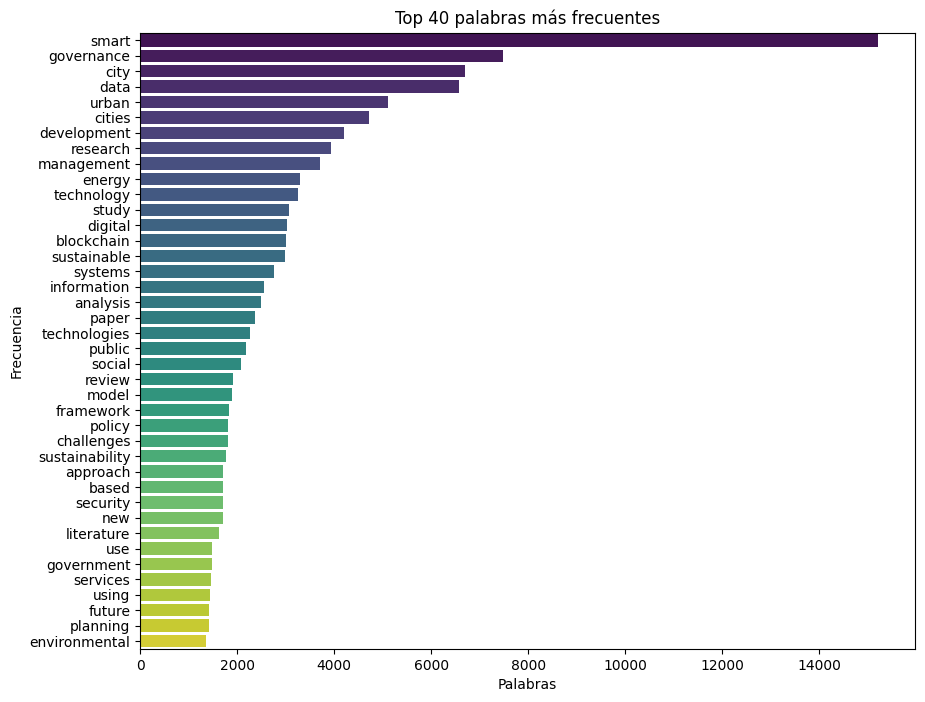

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

# Vectorizar el texto utilizando CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
word_count = count_vectorizer.fit_transform(df_texts['text'])

# Obtener la suma de las frecuencias de cada palabra
word_counts = word_count.sum(axis=0).A1
word_indices = count_vectorizer.get_feature_names_out()

# Crear un DataFrame con las palabras y sus frecuencias
word_freq = pd.DataFrame({'word': word_indices, 'count': word_counts})

# Ordenar las palabras por frecuencia y seleccionar las 40 más frecuentes
top_words = word_freq.sort_values(by='count', ascending=False).head(40)

# Visualizar las 10 palabras más frecuentes con Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='word', data=top_words, palette='viridis')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Top 40 palabras más frecuentes')
plt.show()

### **Calculamos el TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vec = TfidfVectorizer(
    max_features = 5000,
    stop_words = "english",
    max_df = 0.95,
    min_df = 2
)

features = vec.fit_transform(df_texts.text)

## **Función para mostrar el top 20 de palabras de cada tópico**

In [ ]:
def display_top_words(n_top_words, feature_names, model):
  for i, topic_vec in enumerate(model.components_):
    print('Topic',i,':', end=' ')
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      print(feature_names[fid], end=' ')
    print()

## **Función para etiquetar el dataset con los tópicos**

In [ ]:
def topic_table(n_top_words, feature_names, model):
  topics = {}
  for i, topic_vec in enumerate(model.components_):
    topic_desc = ''
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      topic_desc = topic_desc + feature_names[fid] + " "
    topics[i] = topic_desc
  return pd.DataFrame({'Top_Topic_Terms': topics})

## **LDA**

Aplicamos el algoritmo LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 5
random_state = 42

lda = LatentDirichletAllocation(n_components=n_topics, random_state=random_state)
lda.fit(features)

LatentDirichletAllocation(n_components=5, random_state=42)

Mostramos las 20 palabras clave para cada tópico

In [ ]:
display_top_words(20, vec.get_feature_names_out(), lda)

Topic 0 : addleton publishers estimates vaccine offshore kpmg thingsenabled compiled ri completed calculated icma um internet sensor serbia performed networked scc pareto 
Topic 1 : smart city urban data cities governance energy development digital management research sustainable technology information study systems public technologies analysis social 
Topic 2 : energy electricity grid renewable plastic power tax hydrogen solar wind battery grids cocoa load microgrids packaging p2p peertopeer voltage microgrid 
Topic 3 : blockchain decentralized contracts contract distributed security ledger blockchainbased voting secure privacy transaction applications blockchains consensus autonomous daos authentication edge network 
Topic 4 : telehealth beta telemedicine cardiovascular container des lake rehabilitation pediatric les surgery imaging la rri mountain cardiac servants medication rheumatology superblock 


Asignamos etiquetas descriptivas para cada tópico

In [ ]:
df_lda = df.copy()

# Etiquetar tópicos con los 20 términos principales
topic_df_lda = topic_table(20, vec.get_feature_names_out(), lda)

# Etiquetar topicos manualmente
topic_df_lda['Label'] = ['Evaluación de Tecnologías y Consultoría en Redes', 'Ciudades Inteligentes y Gestión Urbana',
                         'Energía Renovable y Redes Eléctricas', 'Blockchain y Seguridad de Datos', 'Telemedicina y Salud Digital']

# Obtener el peso para clasificar el dataset
document_weights = lda.transform(vec.transform(df_texts['text']))

# Almacenar los temas más representativos
df_lda["Topic_lda_idx"] = document_weights.argmax(axis=1)

# Añadir las eiquetas al dataset
df_lda = pd.merge(df_lda, topic_df_lda, left_on='Topic_lda_idx', right_index=True, how='left')

In [ ]:
df_lda

,Source,title,doi,abstract,keywords,Year,Source title,Funding Details,References,Affiliations,...,Editors,Publisher,Sponsors,Abbreviated Source Title,Document Type,Publication Stage,number,Topic_lda_idx,Top_Topic_Terms,Label
0,Scopus,explaining nonadoption blockchain technology g...,10.1007/s40812-023-00296-8,business potential blockchain technology globa...,blockchain d21 d22 f23 general purpose technol...,2024,journal industrial business economics,NaN,annals transaction cost theory past progress c...,fhnw school business university applied scienc...,...,NaN,springer nature,NaN,j ind bus econ,article,final,NaN,1,smart city urban data cities governance energy...,Ciudades Inteligentes y Gestión Urbana
1,Scopus,smartcircular strategies managing biomass reso...,10.1016/j.enconman.2024.118690,growing global population need sustainable ene...,biomass management challenges cifdematel cifqf...,2024,energy conversion management,NaN,feleke cole sm sekabira h djouaka r manyong v ...,management department faculty economics manage...,...,NaN,elsevier ltd,NaN,energy convers manage,article,final,NaN,1,smart city urban data cities governance energy...,Ciudades Inteligentes y Gestión Urbana
2,Scopus,blockchain urban governance enhancing trust sm...,10.1016/j.scs.2024.105438,rapid urbanization increasing energy demands n...,blockchain long shortterm memory smart cities ...,2024,sustainable cities society,NaN,ahad paiva tripathi g feroz n enabling technol...,college building environment engineering zheng...,...,NaN,elsevier ltd,NaN,sustainable cities soc,article,final,NaN,1,smart city urban data cities governance energy...,Ciudades Inteligentes y Gestión Urbana
3,Scopus,data mesh meets blockchain,10.1007/s44196-024-00404-z,effective dataset management crucial enterpris...,blockchain data mesh dataset governance datase...,2024,international journal computational intelligen...,king saud university ksu,halevy korn f noy nf olston c polyzotis n roy ...,department information systems college compute...,...,NaN,springer science business media bv,NaN,int j comput intell syst,article,final,NaN,1,smart city urban data cities governance energy...,Ciudades Inteligentes y Gestión Urbana
4,Scopus,wise investment urban governments evidence int...,10.1016/j.asieco.2024.101730,pursuit sustainable development goals become i...,community sports centers intelligent buildings...,2024,journal asian economics,ministry science technology taiwan 1102410h007...,agha n rascher economic development effects ma...,department quantitative finance national tsing...,...,NaN,elsevier bv,NaN,j asian econ,article,final,NaN,1,smart city urban data cities governance energy...,Ciudades Inteligentes y Gestión Urbana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846,ScienceDirect,ai business management tracking future researc...,https://doi.org/10.1016/j.heliyon.2023.e23902,study designed analyse academic landscape ai s...,bibliometric analysis artificial intelligence ...,2024,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,smart city urban data cities governance energy...,Ciudades Inteligentes y Gestión Urbana
3847,ScienceDirect,scientometric analysis knowledge transfer part...,https://doi.org/10.1016/j.joitmc.2024.100325,era digital transformation dt reshapes industr...,digital transformation knowledge transfer part...,2024,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1,smart city urban data cities governance energy...,Ciudades Inteligentes y Gestión Urbana
3848,ScienceDirect,cybersecurity awareness children systematic li...,https://doi.org/10.1016/j.ijcci.2021.100343,cybersecurity children received much attention...,cybersecurity online security awareness childr...,2021,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,smart city urban data cities governance energy...,Ciudades Inteligentes y Gestión Urbana
3849,ScienceDirect,transition perspective energy communities syst...,https://doi.org/10.1016/j.rser.2022.112479,advantages energy

## **NMF**

Aplicamos el algoritmo NMF

In [ ]:
from sklearn.decomposition import NMF
n_topics = 5
random_state = 42

nmf = NMF(n_components=n_topics, random_state=random_state)
nmf.fit(features)

NMF(n_components=5, random_state=42)

Mostramos las 20 palabras clave para cada tópico

In [ ]:
display_top_words(20, vec.get_feature_names_out(), nmf)

Topic 0 : smart city urban cities development governance sustainable planning study public citizens technology mobility government information local concept infrastructure services analysis 
Topic 1 : blockchain technology security decentralized contracts iot contract smart distributed applications ledger chain supply privacy healthcare internet consensus systems blockchainbased network 
Topic 2 : energy renewable power transition grid systems electricity transitions grids review smart efficiency distributed storage communities electric community consumption trading carbon 
Topic 3 : data big information iot management privacy internet sharing governance things analytics learning security digital computing platform quality cloud systems open 
Topic 4 : digital climate sustainable sustainability ai food water research management environmental development review health change social innovation policy intelligence governance artificial 


Asignamos etiquetas descriptivas para cada tópico

In [ ]:
df_nmf = df.copy()

# Etiquetar tópicos con los 20 términos principales
topic_df_nmf = topic_table(20, vec.get_feature_names_out(), nmf)

# Etiquetar topicos manualmente
topic_df_nmf['Label'] = ['Gobernanza y Desarrollo en Ciudades Inteligentes', 'Tecnología Blockchain y Seguridad en IoT', 'Transición y Eficiencia Energética',
                         'Gestión de Datos y Seguridad Digital', 'Inteligencia Artificial y Sostenibilidad Ambiental']

# Obtener el peso para clasificar el dataset
document_weights = nmf.transform(vec.transform(df_texts['text']))

# Almacenar los temas más representativos
df_nmf["Topic_nmf_idx"] = document_weights.argmax(axis=1)

# Añadir las eiquetas al dataset
df_nmf = pd.merge(df_nmf, topic_df_nmf, left_on='Topic_nmf_idx', right_index=True, how='left')

In [ ]:
df_nmf

,Source,title,doi,abstract,keywords,Year,Source title,Funding Details,References,Affiliations,...,Editors,Publisher,Sponsors,Abbreviated Source Title,Document Type,Publication Stage,number,Topic_nmf_idx,Top_Topic_Terms,Label
0,Scopus,explaining nonadoption blockchain technology g...,10.1007/s40812-023-00296-8,business potential blockchain technology globa...,blockchain d21 d22 f23 general purpose technol...,2024,journal industrial business economics,NaN,annals transaction cost theory past progress c...,fhnw school business university applied scienc...,...,NaN,springer nature,NaN,j ind bus econ,article,final,NaN,1,blockchain technology security decentralized c...,Tecnología Blockchain y Seguridad en IoT
1,Scopus,smartcircular strategies managing biomass reso...,10.1016/j.enconman.2024.118690,growing global population need sustainable ene...,biomass management challenges cifdematel cifqf...,2024,energy conversion management,NaN,feleke cole sm sekabira h djouaka r manyong v ...,management department faculty economics manage...,...,NaN,elsevier ltd,NaN,energy convers manage,article,final,NaN,4,digital climate sustainable sustainability ai ...,Inteligencia Artificial y Sostenibilidad Ambie...
2,Scopus,blockchain urban governance enhancing trust sm...,10.1016/j.scs.2024.105438,rapid urbanization increasing energy demands n...,blockchain long shortterm memory smart cities ...,2024,sustainable cities society,NaN,ahad paiva tripathi g feroz n enabling technol...,college building environment engineering zheng...,...,NaN,elsevier ltd,NaN,sustainable cities soc,article,final,NaN,2,energy renewable power transition grid systems...,Transición y Eficiencia Energética
3,Scopus,data mesh meets blockchain,10.1007/s44196-024-00404-z,effective dataset management crucial enterpris...,blockchain data mesh dataset governance datase...,2024,international journal computational intelligen...,king saud university ksu,halevy korn f noy nf olston c polyzotis n roy ...,department information systems college compute...,...,NaN,springer science business media bv,NaN,int j comput intell syst,article,final,NaN,3,data big information iot management privacy in...,Gestión de Datos y Seguridad Digital
4,Scopus,wise investment urban governments evidence int...,10.1016/j.asieco.2024.101730,pursuit sustainable development goals become i...,community sports centers intelligent buildings...,2024,journal asian economics,ministry science technology taiwan 1102410h007...,agha n rascher economic development effects ma...,department quantitative finance national tsing...,...,NaN,elsevier bv,NaN,j asian econ,article,final,NaN,4,digital climate sustainable sustainability ai ...,Inteligencia Artificial y Sostenibilidad Ambie...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846,ScienceDirect,ai business management tracking future researc...,https://doi.org/10.1016/j.heliyon.2023.e23902,study designed analyse academic landscape ai s...,bibliometric analysis artificial intelligence ...,2024,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4,digital climate sustainable sustainability ai ...,Inteligencia Artificial y Sostenibilidad Ambie...
3847,ScienceDirect,scientometric analysis knowledge transfer part...,https://doi.org/10.1016/j.joitmc.2024.100325,era digital transformation dt reshapes industr...,digital transformation knowledge transfer part...,2024,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4,digital climate sustainable sustainability ai ...,Inteligencia Artificial y Sostenibilidad Ambie...
3848,ScienceDirect,cybersecurity awareness children systematic li...,https://doi.org/10.1016/j.ijcci.2021.100343,cybersecurity children received much attention...,cybersecurity online security awareness childr...,2021,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,digital climate sustainable sustainability ai ...,Inteligencia Artificial y Sostenibilidad Ambie...
3849,ScienceDirect,transition perspective energy communities syst...,https://d

## **Evaluamos la coherencia de los tópicos**

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Creamos el corpus

In [ ]:
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import spacy

# Descargamos los recursos necesarios
nltk.download('punkt')
nltk.download('wordnet')

df_tokens = df_texts.copy()

# Cargar el modelo de lenguaje inglés de spaCy
nlp = spacy.load('en_core_web_sm')

# Inicializamos el lematizador de WordNet
lemmatizer = WordNetLemmatizer()

# Función para obtener la etiqueta POS de WordNet desde spaCy POS tag
def get_wordnet_pos(spacy_tag):
    if spacy_tag.startswith('N'):
        return wordnet.NOUN
    elif spacy_tag.startswith('V'):
        return wordnet.VERB
    elif spacy_tag.startswith('J'):
        return wordnet.ADJ
    elif spacy_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Función para lematizar el texto basado en POS tagging
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_tokens = []
    for token in doc:
        wordnet_pos = get_wordnet_pos(token.tag_)
        lemmatized_token = lemmatizer.lemmatize(token.text, pos=wordnet_pos)
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

# Función para tokenizar el texto
def preprocess_text(text):
    tokens = lemmatize_text(text)  # Lematización
    tokens = [token for token in tokens if token.isalpha()]  # Eliminar tokens que no son palabras
    return tokens

# Aplicar la tokenización al dataframe
df_tokens['tokens'] = df_tokens['text'].apply(preprocess_text)

# Crear el diccionario de Gensim
dictionary = Dictionary(df_tokens['tokens'])

# Filtrar términos muy frecuentes o raros en el diccionario
dictionary.filter_extremes(no_below=2, no_above=0.95)  # Ejemplo de filtrado

# Crear el corpus: representación de Bolsa de Palabras (BoW)
corpus = [dictionary.doc2bow(tokens) for tokens in df_tokens['tokens']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Creamos un modelo LDA de prueba

In [ ]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

# Crear el modelo LDA
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,  # Número inicial de temas
                     random_state=42,
                     passes=10,       # Número de pasadas por el corpus
                     per_word_topics=True)

Observamos el número óptimo de tópicos

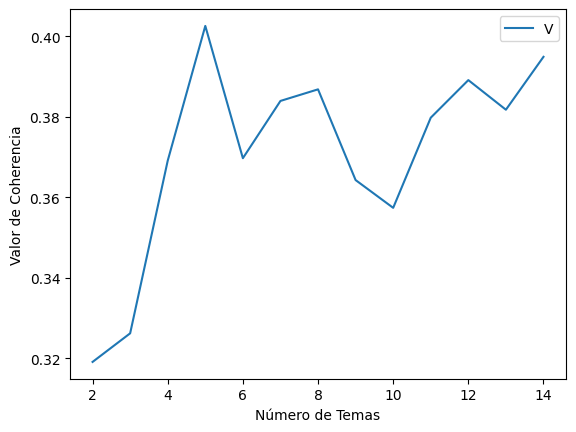

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

# Ejecutar la función para obtener los valores de coherencia
start = 2
limit = 15
step = 1
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df_tokens['tokens'], start=start, limit=limit, step=step)

# Mostrar los valores de coherencia
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Número de Temas")
plt.ylabel("Valor de Coherencia")
plt.legend(("Valores de Coherencia"), loc='best')
plt.show()

Podemos observar que el valor máximo de coherencia es alcazando cuando número de tópicos es 5, por lo que podemos decir que es el número óptimo para obtener una representación más coherente y significativa de los artículos.

Vizualizamos los resultados con PyLDAvis

In [40]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Crear la visualización de pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Mostrar la visualización en el notebook
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Distribución de Documentos en Tópicos**

LDA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


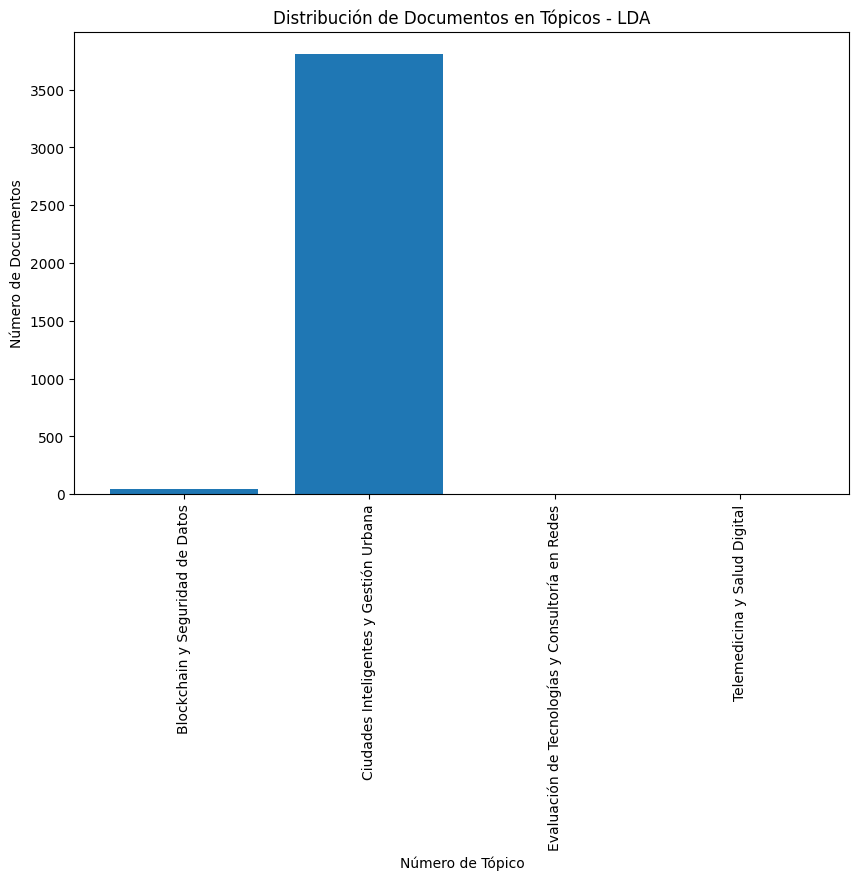

In [ ]:
import matplotlib.pyplot as plt

topic_distribution = df_lda['Label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(topic_distribution.index, topic_distribution.values, tick_label=[f'{i}' for i in topic_distribution.index])
plt.xlabel("Número de Tópico")
plt.ylabel("Número de Documentos")
plt.title("Distribución de Documentos en Tópicos - LDA")
plt.xticks(rotation=90)
plt.show()

NMF

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


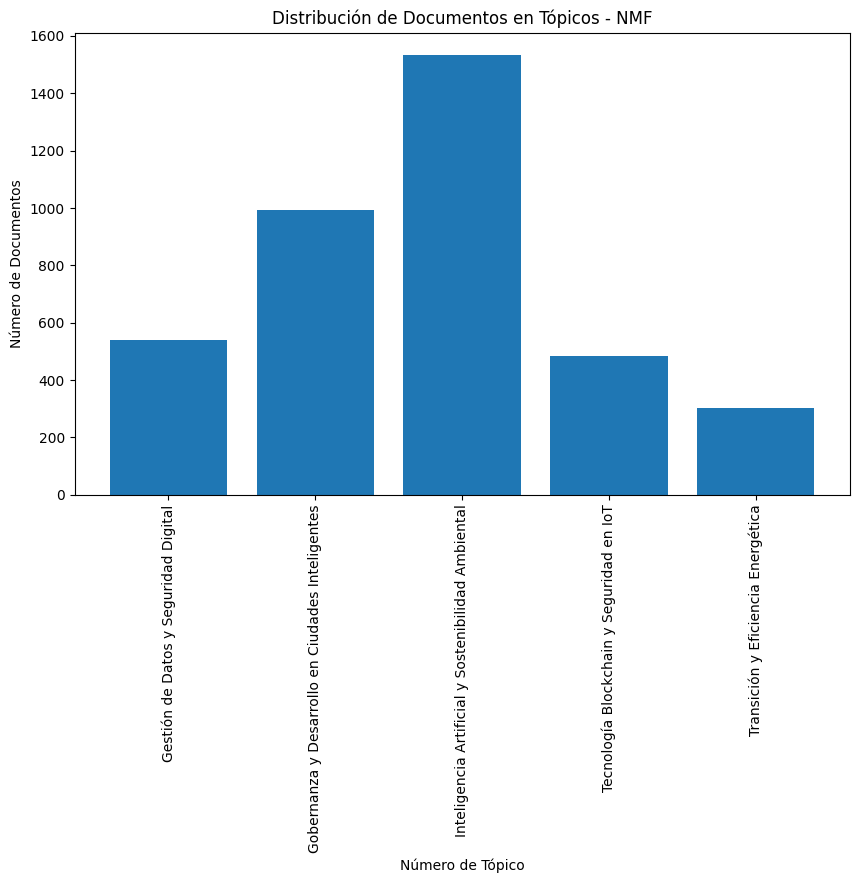

In [ ]:
import matplotlib.pyplot as plt

topic_distribution = df_nmf['Label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(topic_distribution.index, topic_distribution.values, tick_label=[f'{i}' for i in topic_distribution.index])
plt.xlabel("Número de Tópico")
plt.ylabel("Número de Documentos")
plt.title("Distribución de Documentos en Tópicos - NMF")
plt.xticks(rotation=90)
plt.show()

## **Nube de palabras más relevantes de cada modelo**

LDA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


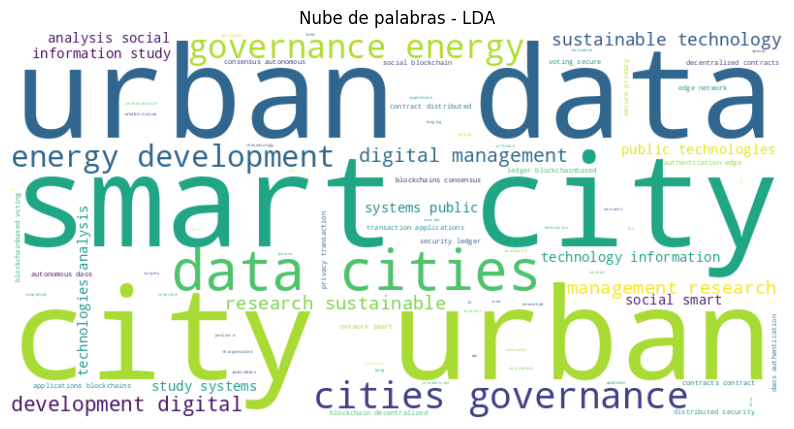

In [ ]:
from wordcloud import WordCloud

# Unir todos los textos de las quejas
all_text = ' '.join(df_lda['Top_Topic_Terms'])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - LDA')
plt.show()

NMF

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


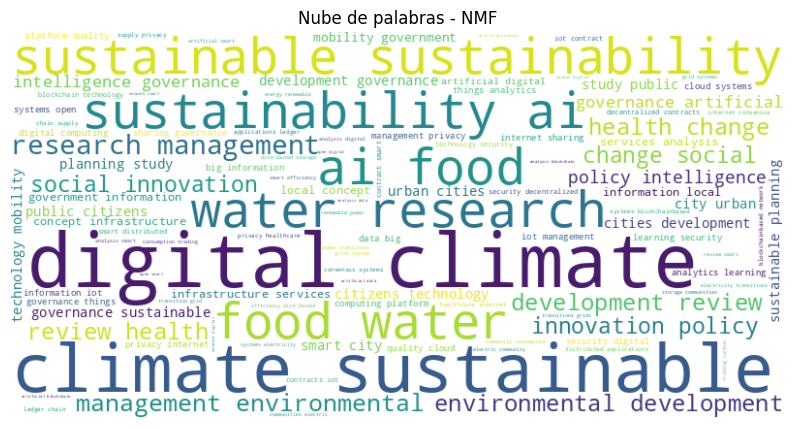

In [ ]:
from wordcloud import WordCloud

# Unir todos los textos de las quejas
all_text = ' '.join(df_nmf['Top_Topic_Terms'])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - NMF')
plt.show()

## **Conclusiones**

En base a los resultados podemos realizar varias conclusiones sobre el tema principal "Smart Governance". A partir del análisis de los artículos científicos, y utilizando técnicas de modelado no supervisado como LDA y NMF, identificamos y clasificamos los artículos en distintos tópicos, cada uno con sus conceptos clave, palabras importantes, métodos usados, métricas relevantes, entidades, y beneficios asociados.

**Modelo LDA**

**Tópico 0:** Evaluación de Tecnologías y Consultoría en Redes
* **Aspectos importantes:** Este tópico se centra en la evaluación y asesoramiento en tecnologías y redes. La mención de empresas de consultoría y tecnologías sugiere una focalización en la optimización de infraestructuras tecnológicas y la implementación de sistemas avanzados.

* **Métodos usados:** Consultoría tecnológica, análisis de sistemas, implementación de sensores y redes inteligentes.

* **Métricas:** Desempeño de la red, eficiencia de sistemas, tiempos de implementación.

* **Entidades:** Empresas de consultoría tecnológica, proveedores de servicios de red.

* **Beneficios:** Mejora en la infraestructura tecnológica, eficiencia en redes y sistemas, optimización de recursos tecnológicos.

**Tópico 1:** Ciudades Inteligentes y Gestión Urbana

* **Aspectos importantes:** Este tópico aborda la gestión y desarrollo de ciudades inteligentes, con un enfoque en la sostenibilidad, la calidad de vida urbana y la participación ciudadana. La tecnología y la información son cruciales para la gobernanza urbana efectiva.

* **Métodos usados:** Implementación de tecnologías digitales en la gestión urbana, desarrollo de infraestructura sostenible, participación ciudadana en la toma de decisiones.

* **Métricas:** Calidad de vida urbana, eficiencia en la prestación de servicios, participación ciudadana.

* **Entidades:** Gobiernos locales, organizaciones urbanas, empresas de tecnología.

* **Beneficios:** Mejora en la prestación de servicios urbanos, desarrollo sostenible, mayor participación y satisfacción ciudadana.

**Tópico 2:** Energía Renovable y Redes Eléctricas

* **Aspectos importantes:** Este tópico se enfoca en la transición hacia energías renovables y la optimización de las redes eléctricas. La eficiencia energética y la reducción de la huella de carbono son puntos clave.

* **Métodos usados:** Desarrollo e integración de redes inteligentes, almacenamiento de energía, implementación de sistemas de energía renovable.

* **Métricas:** Eficiencia energética, reducción de emisiones de carbono, capacidad de almacenamiento de energía.

* **Entidades:** Compañías de energía, comunidades energéticas, proveedores de tecnología de energía renovable.

* **Beneficios:** Eficiencia energética, sostenibilidad ambiental, reducción de la dependencia de fuentes de energía no renovables.

**Tópico 3:** Blockchain y Seguridad de Datos

* **Aspectos importantes:** Este tópico trata sobre el uso de blockchain y la seguridad de datos, destacando su aplicación en contratos inteligentes, IoT y privacidad.

* **Métodos usados:** Sistemas ledger distribuidos, contratos inteligentes, tecnología de blockchain para la seguridad de datos.

* **Métricas:** Integridad de los datos, seguridad y privacidad, eficiencia en transacciones.

* **Entidades:** Empresas de tecnología blockchain, sectores de salud y suministros.

* **Beneficios:** Mayor seguridad y privacidad en la gestión de datos, transparencia en transacciones, eficiencia operativa.

**Tópico 4:** Telemedicina y Salud Digital

* **Aspectos importantes:** Este tópico se centra en la telemedicina y la salud digital, abarcando el uso de tecnologías digitales para mejorar la accesibilidad y eficiencia en la atención médica.

* **Métodos usados:** Implementación de sistemas de telemedicina, uso de tecnología para monitoreo remoto y diagnóstico por imagen.

* **Métricas:** Accesibilidad a servicios de salud, eficiencia en la atención médica, resultados de salud de los pacientes.

* **Entidades:** Proveedores de servicios de salud, empresas de tecnología médica, instituciones médicas.

* **Beneficios:** Mejor accesibilidad a servicios de salud, eficiencia en la atención médica, monitoreo continuo y diagnóstico oportuno.


**Modelo NMF**

**Tópico 0:** Gobernanza y Desarrollo en Ciudades Inteligentes

* **Aspectos importantes:** Este tópico se centra en la gobernanza y el desarrollo de ciudades inteligentes, con un enfoque en la tecnología de la información y la comunicación (ICT) para mejorar los servicios públicos y la calidad de vida de los ciudadanos.

* **Métodos usados:** Implementación de tecnologías ICT, desarrollo de modelos de gobernanza inteligente, investigación sobre la participación ciudadana.

* **Métricas:** Mejora en los servicios públicos, participación ciudadana, calidad de vida.

* **Entidades:** Gobiernos locales, organizaciones de investigación, empresas de tecnología.

* **Beneficios:** Mejoras en la gobernanza urbana, eficiencia en los servicios públicos, mayor participación y satisfacción ciudadana.

**Tópico 1:** Tecnología Blockchain y Seguridad en IoT

* **Aspectos importantes:** Este tópico aborda la aplicación de la tecnología blockchain para mejorar la seguridad en el Internet de las Cosas (IoT), incluyendo contratos inteligentes y sistemas descentralizados.

* **Métodos usados:** Uso de tecnología blockchain, implementación de contratos inteligentes, desarrollo de aplicaciones descentralizadas.

* **Métricas:** Seguridad de los datos, privacidad, eficiencia de las transacciones.

* **Entidades:** Empresas de tecnología, sectores de salud y logística.

* **Beneficios:** Mayor seguridad y privacidad en sistemas IoT, transparencia en transacciones, reducción de fraudes.

**Tópico 2:** Transición Energética y Sistemas de Energía

* **Aspectos importantes:** Este tópico se centra en la transición hacia energías renovables y la optimización de los sistemas de energía, destacando la importancia de la eficiencia energética y la sostenibilidad.

* **Métodos usados:** Implementación de redes inteligentes, almacenamiento de energía, desarrollo de sistemas de energía renovable.

* **Métricas:** Eficiencia energética, reducción de emisiones de carbono, capacidad de almacenamiento.

* **Entidades:** Compañías de energía, comunidades energéticas, proveedores de tecnología.

* **Beneficios:** Sostenibilidad energética, reducción de la huella de carbono, mayor eficiencia en el consumo energético.

**Tópico 3:** Gestión de Datos y Seguridad Digital

* **Aspectos importantes:** Este tópico se enfoca en la gestión de grandes volúmenes de datos (Big Data) y la seguridad digital, destacando la importancia de la privacidad y la calidad de la información.

* **Métodos usados:** Análisis de Big Data, gestión de la privacidad de datos, implementación de plataformas de computación en la nube.

* **Métricas:** Calidad de los datos, seguridad y privacidad, eficiencia en el análisis de datos.

* **Entidades:** Empresas de tecnología, organizaciones de análisis de datos, proveedores de servicios en la nube.

* **Beneficios:** Mejor gestión de datos, mayor seguridad y privacidad, eficiencia en el procesamiento y análisis de datos.

**Tópico 4:** Inteligencia Artificial y Sostenibilidad Ambiental

* **Aspectos importantes:** Este tópico aborda la aplicación de la inteligencia artificial (IA) en la sostenibilidad ambiental, destacando la investigación y el desarrollo de políticas para enfrentar el cambio climático y mejorar la gestión de recursos.

* **Métodos usados:** Uso de IA para la gestión ambiental, investigación sobre sostenibilidad, desarrollo de políticas climáticas.

* **Métricas:** Impacto ambiental, eficiencia en la gestión de recursos, innovación en sostenibilidad.

* **Entidades:** Instituciones de investigación, organizaciones ambientales, empresas de tecnología.

* **Beneficios:** Mejoras en la sostenibilidad ambiental, innovación en la gestión de recursos, políticas efectivas contra el cambio climático.